## 0. Import libraries used

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Load and Explore the Dataset

In [3]:
df = pd.read_csv('priority_order_clustering_dataset.csv')

In [4]:
df.head()

,Order Quantity,Order Value,Distance to Warehouse,Delivery Time,Time to Due Date
0,668,6482.264479,1485.083172,7.648508,10.195798
1,651,9743.234716,1697.608631,1.123710,1.100956
2,633,8478.255228,848.145248,3.235386,16.285398
3,577,284.769898,609.347157,2.929658,15.683382
4,619,8990.678017,653.963792,3.437257,11.419964


In [5]:
df.describe()

,Order Quantity,Order Value,Distance to Warehouse,Delivery Time,Time to Due Date
count,200.00000,200.000000,200.000000,200.000000,200.000000
mean,533.87500,5058.204016,1031.542205,5.295681,11.239889
std,293.19779,3029.449488,569.397219,2.508727,5.525743
min,3.00000,50.115766,21.598285,1.017929,1.100956
25%,260.25000,2338.317830,555.135671,3.097469,6.141115
50%,561.50000,4933.544186,1097.550759,5.232541,12.325474
75%,781.00000,7814.663174,1471.258679,7.356583,15.816522
max,993.00000,9948.451975,1969.792514,9.974641,19.978960


## 2. Data Preparation

In [6]:
# Convert the dataset to a numpy array for K-Means clustering
X = df.values
print(f"Data shape: {X.shape} (samples, features)")

Data shape: (200, 5) (samples, features)


## 3. Data Normalization

K-Means clustering uses **Euclidean distance** to measure similarity between data points. Features with larger scales will dominate the distance calculation, causing the algorithm to ignore features with smaller scales.

We use **Min-Max normalization** to scale all features to the range [0, 1], ensuring each feature contributes equally to the distance calculations:
- Formula: `(value - min) / (max - min)`
- Result: All features have the same scale (0 to 1)

In [7]:
X_normalized = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

## 4. K-Means Clustering Implementation

In [8]:
class KMeansClustering:
    def __init__(self, n_clusters=3, max_iters=100, n_init=10):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.n_init = n_init
        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = None

    def _euclidean_distance(self, point1, point2):
        return np.sqrt(np.sum((point1 - point2) ** 2))

    def _init_centroids(self, X):
        n_samples, n_features = X.shape
        centroids = np.zeros((self.n_clusters, n_features))
        centroids[0] = X[np.random.randint(n_samples)]

        for k in range(1, self.n_clusters):
            min_distances = np.zeros(n_samples)
            for i in range(n_samples):
                distances = [self._euclidean_distance(X[i], centroids[j]) for j in range(k)]
                min_distances[i] = min(distances) ** 2

            probs = min_distances / np.sum(min_distances)
            r = np.random.rand()
            centroids[k] = X[np.searchsorted(np.cumsum(probs), r)]

        return centroids

    def _assign_clusters(self, X, centroids):
        labels = np.zeros(len(X), dtype=int)
        for i in range(len(X)):
            distances = [self._euclidean_distance(X[i], centroids[k]) for k in range(self.n_clusters)]
            labels[i] = np.argmin(distances)
        return labels

    def _update_centroids(self, X, labels):
        n_features = X.shape[1]
        centroids = np.zeros((self.n_clusters, n_features))
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                centroids[k] = cluster_points.mean(axis=0)
        return centroids

    def _compute_inertia(self, X, labels, centroids):
        total_distance = 0
        for i in range(len(X)):
            cluster = labels[i]
            total_distance += self._euclidean_distance(X[i], centroids[cluster]) ** 2
        return total_distance

    def fit(self, X):
        best_inertia = float('inf')
        best_centroids = None
        best_labels = None

        for _ in range(self.n_init):
            centroids = self._init_centroids(X)
            for _ in range(self.max_iters):
                old_centroids = centroids.copy()
                labels = self._assign_clusters(X, centroids)
                centroids = self._update_centroids(X, labels)
                if np.allclose(old_centroids, centroids):
                    break

            inertia = self._compute_inertia(X, labels, centroids)
            if inertia < best_inertia:
                best_inertia = inertia
                best_centroids = centroids
                best_labels = labels

        self.cluster_centers_ = best_centroids
        self.labels_ = best_labels
        self.inertia_ = best_inertia
        return self

    def predict(self, X):
        if self.cluster_centers_ is None:
            raise ValueError("Model must be fitted before making predictions")
        return self._assign_clusters(X, self.cluster_centers_)

## 5. Run K-Means Clustering

Based on business context, we use **k = 4** clusters representing:
1. **Low Priority / Low Importance**
2. **Low Priority / High Importance**
3. **High Priority / Low Importance**
4. **High Priority / High Importance**

In [9]:
k = 4
kmeans = KMeansClustering(n_clusters=k, max_iters=100, n_init=10)
kmeans.fit(X_normalized)

df_clustered = df.copy()
df_clustered['Cluster'] = kmeans.labels_

## 6. Cluster Statistics

In [10]:
df_clustered.groupby('Cluster').mean()

,Order Quantity,Order Value,Distance to Warehouse,Delivery Time,Time to Due Date
Cluster,,,,,
0,495.750000,8438.800687,1057.261691,3.602143,10.471987
1,541.857143,4976.360618,1366.121328,7.814170,16.094333
2,794.800000,3997.985420,1046.309831,5.547367,6.383829
3,300.102041,2634.331145,654.599928,4.317594,12.155524


## 7. Visualizations

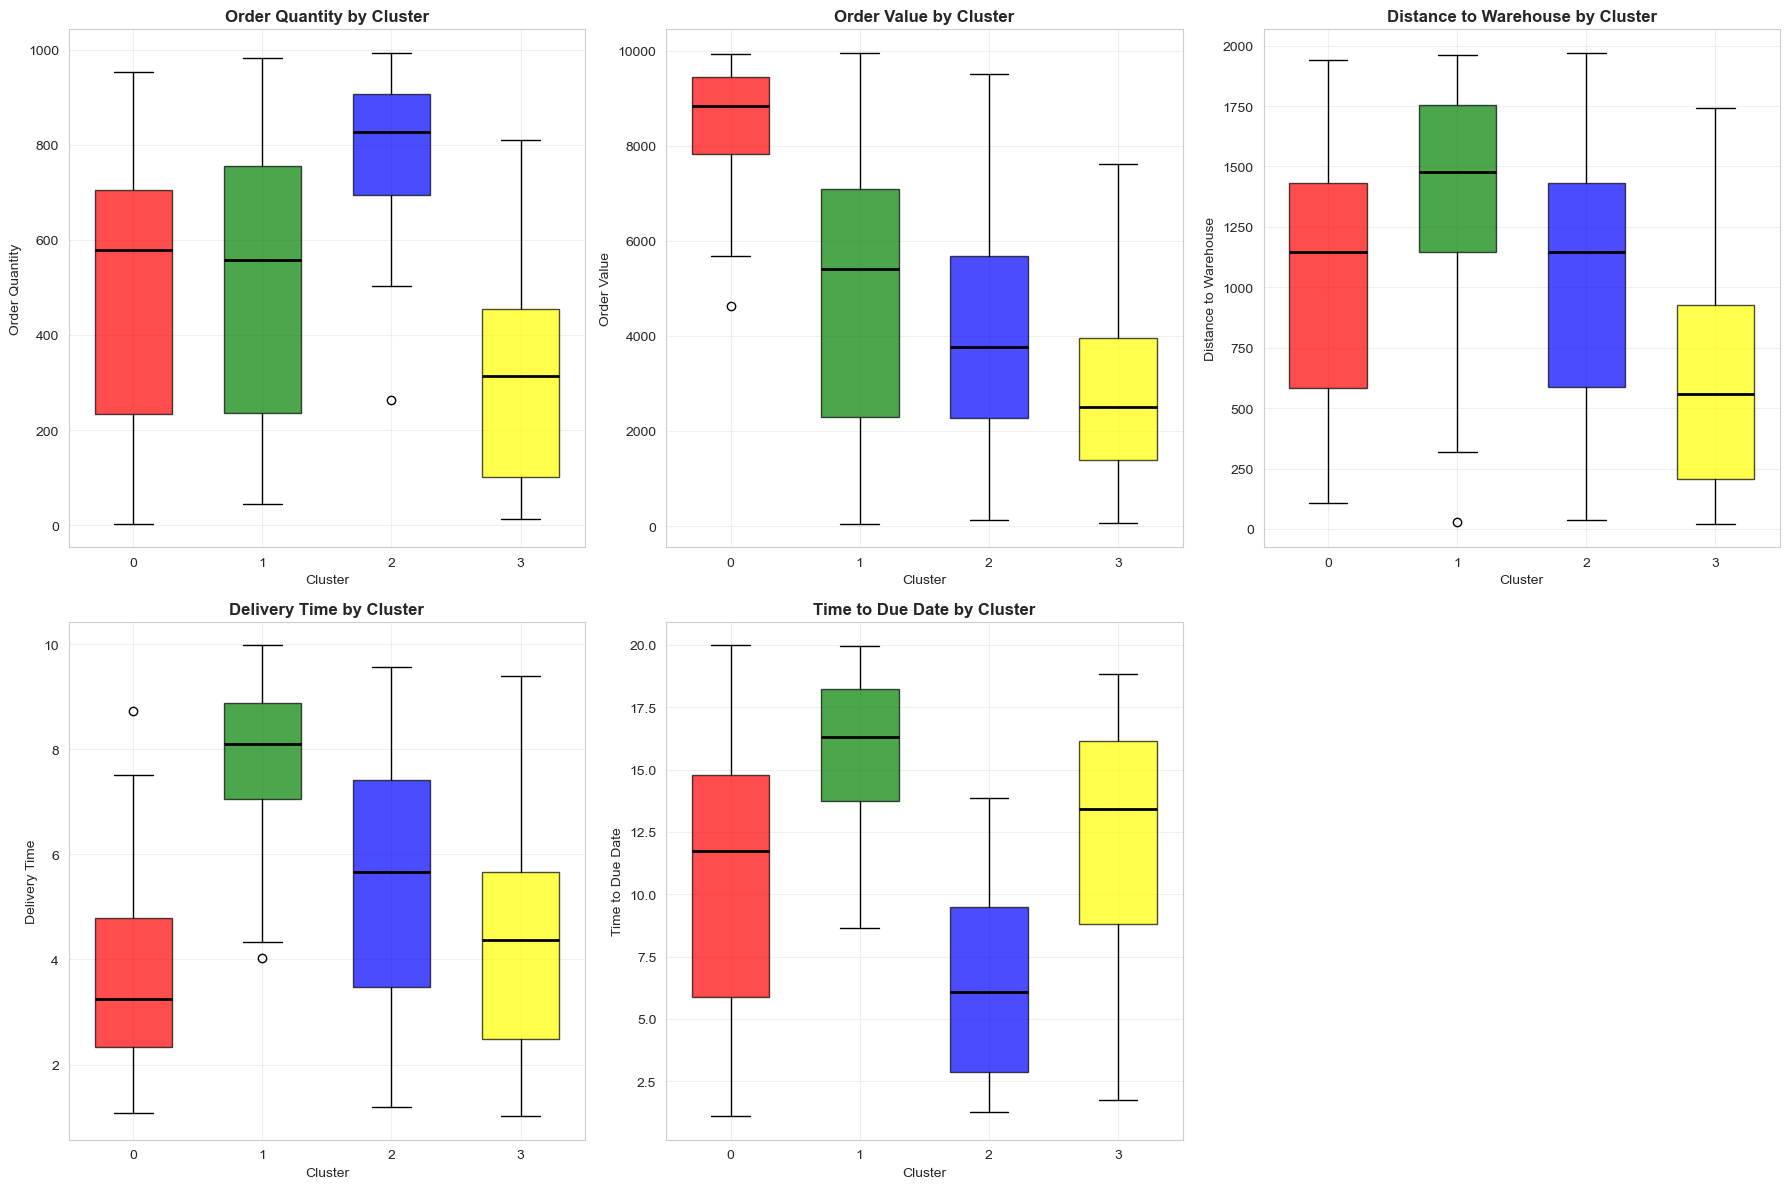

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()
colors = ['red', 'green', 'blue', 'yellow']

for i, col in enumerate(df.columns):
    for cluster in range(kmeans.n_clusters):
        cluster_data = df_clustered[df_clustered['Cluster'] == cluster][col]
        axes[i].boxplot([cluster_data], positions=[cluster], widths=0.6,
                       patch_artist=True,
                       boxprops=dict(facecolor=colors[cluster % len(colors)], alpha=0.7),
                       medianprops=dict(color='black', linewidth=2))
    axes[i].set_title(f'{col} by Cluster', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(col)
    axes[i].set_xticks(range(kmeans.n_clusters))
    axes[i].grid(True, alpha=0.3)

axes[-1].set_visible(False)
plt.tight_layout()
plt.show()

## 8. Cluster Interpretation

**Feature Selection Rationale:** The 4 business categories are defined by two dimensions:
- **Priority** (urgency): How urgent the order is
- **Importance** (business value): How valuable the order is to the business

**Choice of "Time to Due Date" for Priority:**
- Directly measures customer urgency (less time remaining = higher priority)
- Represents the customer-facing deadline
- More relevant than "Delivery Time" (which is an internal logistics metric)

**Choice of "Order Value" for Importance:**
- Directly measures financial impact (revenue)
- Reflects business importance and customer value
- More relevant than "Order Quantity" (volume ≠ value; a small high-value order can be more important)

While K-Means uses all 5 features for clustering, only these two features are used for post-clustering business interpretation, as they directly align with the Priority/Importance framework.

In [12]:
mean_due = df['Time to Due Date'].mean()
mean_value = df['Order Value'].mean()

business_categories = {
    0: "Low Priority / Low Importance",
    1: "Low Priority / High Importance", 
    2: "High Priority / Low Importance",
    3: "High Priority / High Importance"
}

cluster_metrics = []
for cluster_id in range(kmeans.n_clusters):
    cluster_data = df_clustered[df_clustered['Cluster'] == cluster_id]
    avg_due = cluster_data['Time to Due Date'].mean()
    avg_value = cluster_data['Order Value'].mean()
    
    priority = "High" if avg_due < mean_due else "Low"
    importance = "High" if avg_value > mean_value else "Low"
    
    cluster_metrics.append({
        'cluster_id': cluster_id,
        'priority': priority,
        'importance': importance,
        'avg_due': avg_due,
        'avg_value': avg_value,
        'data': cluster_data
    })

cluster_metrics.sort(key=lambda x: (x['priority'] == 'Low', x['importance'] == 'Low'))

for idx, metrics in enumerate(cluster_metrics):
    cluster_id = metrics['cluster_id']
    category = business_categories[idx]
    cluster_data = metrics['data']
    share = len(cluster_data) / len(df) * 100
    
    print(f"{category} (Cluster {cluster_id}): {len(cluster_data)} orders ({share:.1f}%)")
    print(f"  Avg Value: €{cluster_data['Order Value'].mean():.2f} | "
          f"Avg Time to Due: {cluster_data['Time to Due Date'].mean():.1f} days | "
          f"Priority: {metrics['priority']} | Importance: {metrics['importance']}")

Low Priority / Low Importance (Cluster 0): 52 orders (26.0%)
  Avg Value: €8438.80 | Avg Time to Due: 10.5 days | Priority: High | Importance: High
Low Priority / High Importance (Cluster 2): 50 orders (25.0%)
  Avg Value: €3997.99 | Avg Time to Due: 6.4 days | Priority: High | Importance: Low
High Priority / Low Importance (Cluster 1): 49 orders (24.5%)
  Avg Value: €4976.36 | Avg Time to Due: 16.1 days | Priority: Low | Importance: Low
High Priority / High Importance (Cluster 3): 49 orders (24.5%)
  Avg Value: €2634.33 | Avg Time to Due: 12.2 days | Priority: Low | Importance: Low


## 9. Summary

The K-Means clustering successfully segmented customer orders into **4 business categories**:
- **Low Priority / Low Importance**: Standard orders
- **Low Priority / High Importance**: High-value orders with time flexibility
- **High Priority / Low Importance**: Urgent orders with lower value
- **High Priority / High Importance**: Critical orders requiring immediate attention

This clustering enables the logistics team to prioritize order fulfillment, optimize warehouse operations, and allocate resources efficiently.